## Refiners Demo

This notebook aims to demonstrate the basics of using the [Refiners](https://github.com/finegrain-ai/refiners) micro-framework.


In [1]:
# to run you need to have `Refiners` installed (uncomment the line below)
# %pip install git+https://github.com/finegrain-ai/refiners.git

In [2]:
import torch
from refiners.fluxion import layers as fl, manual_seed
from torch import nn

torch.set_grad_enabled(mode=False)
manual_seed(82570858)

### Basics

The core idea of Refiners is to improve on the `Sequential` API of PyTorch.

A `Sequential` is defined by:

`Sequential([layer1, layer2, layer3])(x) = layer3(layer2(layer1(x)))`

In [3]:
# Native PyTorch sequential
sequential = nn.Sequential(
    fl.Conv2d(3, 32, 3, padding=1),
    nn.ReLU(),
    fl.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    fl.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    fl.Conv2d(32, 32, 3, padding=1),
)

sequential

Sequential(
  (0): Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
)

In [4]:
# Same as above, but with a Fluxion Chain
chain = fl.Chain(
    fl.Conv2d(3, 32, 3, padding=1),
    fl.ReLU(),
    fl.Conv2d(32, 32, 3, padding=1),
    fl.ReLU(),
    fl.Conv2d(32, 32, 3, padding=1),
    fl.ReLU(),
    fl.Conv2d(32, 32, 3, padding=1),
)

chain

(CHAIN)
    ├── Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #1
    ├── ReLU() #1
    ├── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #2
    ├── ReLU() #2
    ├── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #3
    ├── ReLU() #3
    └── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #4

Note here that the keys of the Chain are the names of the layers, whereas in PyTorch Sequential API, the keys are the indices of the layers.


In [5]:
print("Sequential keys:")
for key, _ in sequential.named_children():
    print(key)

print("\nChain keys:")
for key, _ in chain.named_children():
    print(key)

Sequential keys:
0
1
2
3
4
5
6

Chain keys:
Conv2d_1
ReLU_1
Conv2d_2
ReLU_2
Conv2d_3
ReLU_3
Conv2d_4


This choice is made because when a model is simple, it is easy to remember the indices of the layers, but when a model is complex, it is hard to remember the indices of the layers.


We also improved on the Errors to showcase exactly where the error is coming from.


In [ ]:
x = torch.randn(1, 4, 32, 32)
# uncomment to run
# sequential(x)

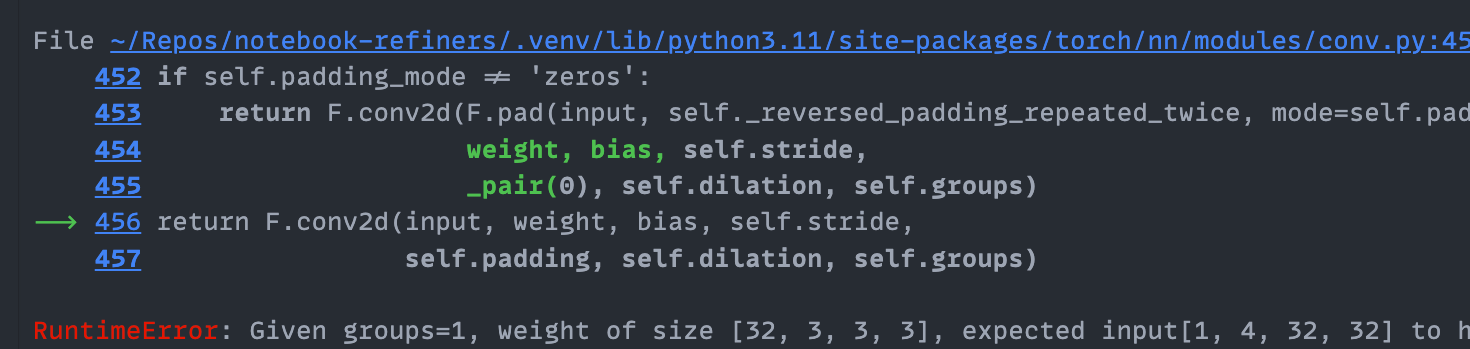

In [ ]:
# uncomment to run
# chain(x)

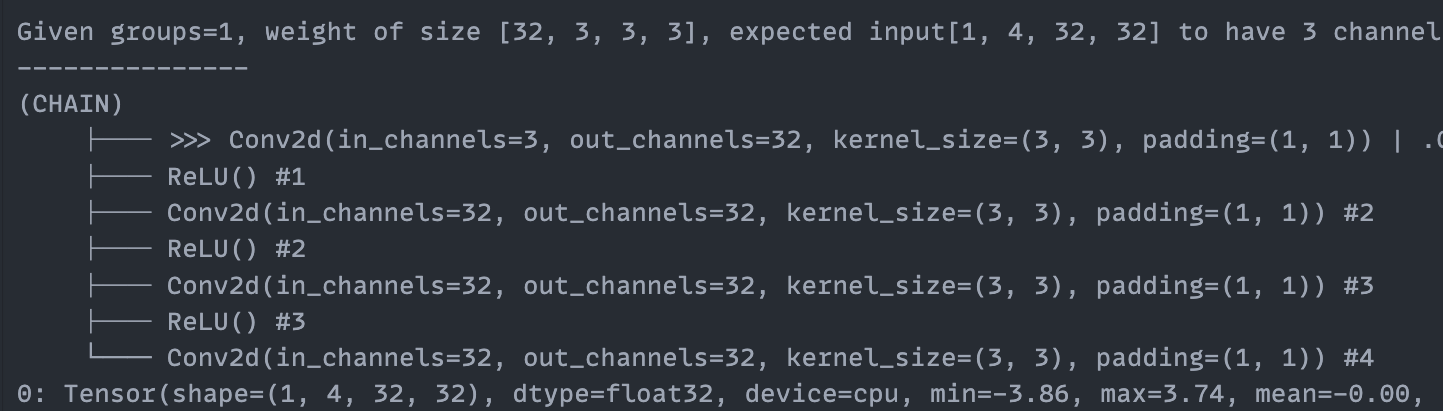

Sequential is excellent for building basic and straightforward models, but most models don't have such a simple linear structure. 

Let's say you want to add a skip connection to the ConvNet.

In [6]:
# ConvNet with a residual connection in PyTorch


class ConvNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.sequential = nn.Sequential(
            fl.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            fl.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            fl.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            fl.Conv2d(32, 32, 3, padding=1),
        )
        self.skip = fl.Conv2d(3, 32, 3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequential(x) + self.skip(x)


convnet = ConvNet()
x = torch.randn(1, 3, 32, 32)
print(convnet(x).shape)
convnet

torch.Size([1, 32, 32, 32])


ConvNet(
  (sequential): Sequential(
    (0): Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
  )
  (skip): Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
)

The `repr` of this PyTorch is not declarative anymore: you cannot know how the model works.

You can use Refiners' predefined `Chain` subclasses to handle such cases and build more complex models.  

Let's start with the `Sum` class.

`fl.Sum([layer1, layer2, layer3])(x) = layer1(x) + layer2(x) + layer3(x)`

In [7]:
# ConvNet with a residual connection in Refiners
convnet = fl.Sum(
    fl.Chain(
        fl.Conv2d(3, 32, 3, padding=1),
        fl.ReLU(),
        fl.Conv2d(32, 32, 3, padding=1),
        fl.ReLU(),
        fl.Conv2d(32, 32, 3, padding=1),
        fl.ReLU(),
        fl.Conv2d(32, 32, 3, padding=1),
    ),
    fl.Conv2d(3, 32, 3, padding=1),
)

x = torch.randn(1, 3, 32, 32)
print(convnet(x).shape)
convnet

torch.Size([1, 32, 32, 32])


(SUM)
    ├── (CHAIN)
    │   ├── Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #1
    │   ├── ReLU() #1
    │   ├── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #2
    │   ├── ReLU() #2
    │   ├── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #3
    │   ├── ReLU() #3
    │   └── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #4
    └── Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=(1, 1))

You can subclass the basics `Chain` to give a name to improve declarativity. The `repr` will still tell you which kind of `Chain` it is and the name of the `Chain`.

In [8]:
class ConvNet(fl.Chain):
    def __init__(self) -> None:
        super().__init__(
            fl.Conv2d(3, 32, 3, padding=1),
            fl.ReLU(),
            fl.Conv2d(32, 32, 3, padding=1),
            fl.ReLU(),
            fl.Conv2d(32, 32, 3, padding=1),
            fl.ReLU(),
            fl.Conv2d(32, 32, 3, padding=1),
        )


class ResidualNet(fl.Sum):
    def __init__(self) -> None:
        super().__init__(
            ConvNet(),
            fl.Conv2d(32, 32, 3, padding=1),
        )


ResidualNet()

(SUM) ResidualNet()
    ├── (CHAIN) ConvNet()
    │   ├── Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #1
    │   ├── ReLU() #1
    │   ├── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #2
    │   ├── ReLU() #2
    │   ├── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #3
    │   ├── ReLU() #3
    │   └── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1)) #4
    └── Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=(1, 1))

Here are some examples of `Chain` subclasses:

In [9]:
# Run layers in parallel to output a tuple
par = fl.Parallel(
    fl.Linear(2, 2),
    fl.Linear(2, 4),
)

x = torch.randn(1, 2)
par(x)  # (Linear_1(x), Linear_2(x))

(tensor([[-0.4723, -0.2809]]), tensor([[-0.5384,  0.6123,  0.2659,  0.0916]]))

In [10]:
# Run layers in parallel and then concatenate the outputs
cat = fl.Concatenate(
    fl.Linear(2, 2),
    fl.Linear(2, 2),
    dim=-1,
)

x = torch.randn(1, 2)
cat(x)  # Concatenate((Linear_1(x), Linear_2(x)), dim=-1)

tensor([[-1.0949,  0.0749,  0.2607,  0.4013]])

In [11]:
# Run sequentially layers and then add the input
residual = fl.Residual(
    fl.Linear(2, 2),
    fl.Linear(2, 2),
)

x = torch.randn(1, 2)
residual(x)  # Linear_2(Linear_1(x)) + x

tensor([[-0.1487, -1.1180]])

Let's now build something more complex such as a Vision Transformer. 

Let's start with the heart of a transformer layer: the Multi-Head Attention.

In [12]:
from refiners.fluxion.layers.attentions import ScaledDotProductAttention


class Attention(fl.Residual):
    def __init__(self, dim: int = 128, num_heads: int = 8) -> None:
        self.dim = dim
        self.num_heads = num_heads
        super().__init__(
            fl.Parallel(
                fl.Linear(dim, dim),
                fl.Linear(dim, dim),
                fl.Linear(dim, dim),
            ),
            ScaledDotProductAttention(num_heads=num_heads),
            fl.Linear(dim, dim),
        )


x = torch.randn(1, 197, 128)
attention = Attention()
print(attention(x).shape)
attention

torch.Size([1, 197, 128])


(RES) Attention()
    ├── (PAR)
    │   └── Linear(in_features=128, out_features=128) (x3)
    ├── ScaledDotProductAttention(num_heads=8)
    └── Linear(in_features=128, out_features=128)

In [13]:
class FeedForward(fl.Residual):
    def __init__(self, dim: int = 128, inner_dim: int = 512) -> None:
        self.dim = dim
        self.inner_dim = inner_dim
        super().__init__(
            fl.Linear(dim, inner_dim),
            fl.SiLU(),
            fl.Linear(inner_dim, dim),
        )


FeedForward()

(RES) FeedForward()
    ├── Linear(in_features=128, out_features=512) #1
    ├── SiLU()
    └── Linear(in_features=512, out_features=128) #2

In [14]:
class TranformerLayer(fl.Chain):
    def __init__(
        self, dim: int = 128, num_heads: int = 8, inner_dim: int = 512
    ) -> None:
        self.dim = dim
        self.num_heads = num_heads
        self.inner_dim = inner_dim
        super().__init__(
            fl.LayerNorm(dim),
            Attention(dim, num_heads),
            fl.LayerNorm(dim),
            FeedForward(dim, inner_dim),
        )


TranformerLayer()

(CHAIN) TranformerLayer()
    ├── LayerNorm(normalized_shape=(128,)) #1
    ├── (RES) Attention()
    │   ├── (PAR)
    │   │   └── Linear(in_features=128, out_features=128) (x3)
    │   ├── ScaledDotProductAttention(num_heads=8)
    │   └── Linear(in_features=128, out_features=128)
    ├── LayerNorm(normalized_shape=(128,)) #2
    └── (RES) FeedForward()
        ├── Linear(in_features=128, out_features=512) #1
        ├── SiLU()
        └── Linear(in_features=512, out_features=128) #2

In [15]:
class PatchEncoder(fl.Chain):
    def __init__(
        self, in_channels: int = 3, dim: int = 128, patch_size: int = 16
    ) -> None:
        self.in_channels = in_channels
        self.dim = dim
        self.patch_size = patch_size
        super().__init__(
            fl.Conv2d(
                in_channels=in_channels,
                out_channels=dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            fl.Reshape(-1, dim),  # Reshape always preserves the batch dimension
        )


x = torch.randn(1, 3, 224, 224)
PatchEncoder()(x).shape

torch.Size([1, 196, 128])

In [16]:
class PositionalToken(fl.Residual):
    def __init__(self, num_patches: int = 196) -> None:
        self.num_patches = num_patches
        super().__init__(fl.Parameter(num_patches, 128))


class ClassToken(fl.Chain):
    def __init__(self, dim: int = 128) -> None:
        self.dim = dim
        super().__init__(fl.Parameter(1, dim))

Now we have every bit to build a full Vision Transformer.

In [17]:
class Transformer(fl.Chain):
    pass


class ViT(fl.Chain):
    def __init__(
        self,
        dim: int = 128,
        patch_size: int = 16,
        image_size: int = 224,
        num_layers: int = 4,
    ) -> None:
        self.dim = dim
        self.patch_size = patch_size
        self.image_size = image_size
        self.num_layers = num_layers
        self.num_patches = (image_size // patch_size) ** 2 + 1
        super().__init__(
            fl.Concatenate(
                PatchEncoder(in_channels=3, dim=dim, patch_size=patch_size),
                ClassToken(dim=dim),
                dim=1,
            ),
            PositionalToken(num_patches=self.num_patches),
            Transformer(TranformerLayer(dim=dim) for _ in range(num_layers)),
        )


x = torch.randn(1, 3, 224, 224)
vit = ViT()
print(repr(vit))
print(vit(x).shape)

(CHAIN) ViT()
    ├── (CAT)
    │   ├── (CHAIN) PatchEncoder()
    │   │   ├── Conv2d(in_channels=3, out_channels=128, kernel_size=(16, 16), stride=(16, 16))
    │   │   └── Reshape(shape=(-1, 128))
    │   └── (CHAIN) ClassToken()
    │       └── Parameter(dims=(1, 128))
    ├── (RES) PositionalToken(num_patches=197)
    │   └── Parameter(dims=(197, 128))
    └── (CHAIN) Transformer()
        └── (CHAIN) TranformerLayer() (x4)
            ├── LayerNorm(normalized_shape=(128,)) #1
            ├── (RES) Attention()
            │   ├── (PAR)
            │   │   └── Linear(in_features=128, out_features=128) (x3)
            │   ├── ScaledDotProductAttention(num_heads=8)
            │   └── Linear(in_features=128, out_features=128)
            ├── LayerNorm(normalized_shape=(128,)) #2
            └── (RES) FeedForward()
                ├── Linear(in_features=128, out_features=512) #1
                ├── SiLU()
                └── Linear(in_features=512, out_features=128) #2
torch.Size([1, 

### Advanced - Context API

This ViT is still rudimentary and linear: we have one input in and one output out. But often, you want to use multiple inputs/modalities in the flow of your model.

Let's take, for example, the `MaskDecoder` of the Segment Anything model by Meta; it's a Transformer that takes as input an image and a prompt and outputs a segmentation mask. You can prompt it with points to guide the segmentation. [Here is a link](https://github.com/finegrain-ai/refiners/blob/main/src/refiners/foundationals/segment_anything/mask_decoder.py) to the complete implementation in Refiners

So the inputs are:

    - an image of shape (3, 224, 224)
    - several points of shape (N, 2) 

One way to consider the points is to add a `CrossAttention` layer that will attend to the points from the image. Cross attention is a standard `Attention` layer, but the key and value come from a source different from the query. In our case, the query is the image, the key and value are the points embeddings.

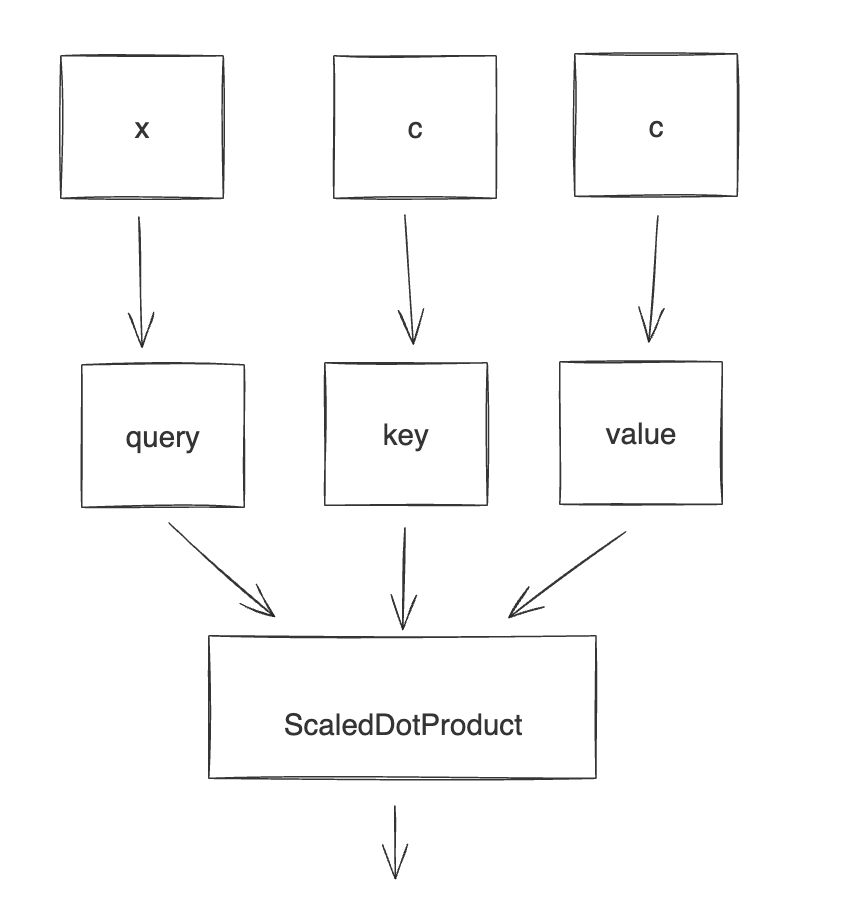


Let's start by building a point encoder (to simplify that all points have the same "meaning").

In [18]:
class PointEncoder(fl.Chain):
    def __init__(self, dim: int = 128) -> None:
        self.dim = dim
        super().__init__(
            fl.Linear(2, dim),
            fl.SiLU(),
            fl.Linear(dim, dim),
            fl.SiLU(),
            fl.Linear(dim, dim),
            fl.Unsqueeze(0),
        )


points = torch.randn(5, 2)
PointEncoder()(points).shape

torch.Size([1, 5, 128])

In [19]:
# Chains can handle multiple inputs
class CrossAttention(fl.Chain):
    def __init__(self, dim: int = 128, num_heads: int = 8) -> None:
        self.dim = dim
        self.num_heads = num_heads
        super().__init__(
            fl.Parallel(
                fl.GetArg(0),
                fl.GetArg(1),
                fl.GetArg(1),
            ),
            fl.Distribute(
                fl.Linear(dim, dim),
                fl.Linear(dim, dim),
                fl.Linear(dim, dim),
            ),
            ScaledDotProductAttention(num_heads=num_heads),
            fl.Linear(dim, dim),
        )


points_embedding = torch.randn(1, 5, 128)
patch_embedding = torch.randn(1, 197, 128)
CrossAttention()(patch_embedding, points_embedding).shape

torch.Size([1, 197, 128])

Now ideally, I would like to insert this `CrossAttention` layer in the middle of the `Transformer` like this:

```python
class TranformerLayer(fl.Chain):
    def __init__(
        self, dim: int = 128, num_heads: int = 8, inner_dim: int = 512
    ) -> None:
        self.dim = dim
        self.num_heads = num_heads
        self.inner_dim = inner_dim
        super().__init__(
            fl.LayerNorm(dim),
            Attention(dim, num_heads),
            fl.LayerNorm(dim),
            CrossAttention(dim, num_heads),
            fl.LayerNorm(dim),
            FeedForward(dim, inner_dim),
        )

```

But how do the `point_embedding` get into the `CrossAttention` layer? That's where the `Context` API comes into play.

In [ ]:
chain = fl.Chain(
    fl.Linear(2, 2),
    fl.Concatenate(
        fl.Linear(2, 2),
        fl.UseContext("embedding", "value"),
        dim=-1,
    ),
    fl.Linear(5, 2),
)

chain.set_context("embedding", {"value": torch.randn(1, 3)})
print(f"Current embedding context: {chain.use_context('embedding')}")

x = torch.randn(1, 2)
chain(x)

Note that the context is recursive, so you can access the context of an outer `Chain` from an inner `Chain`.

We can rewrite the `CrossAttention` layer using context instead of passing the `point_embedding` as an argument.

In [20]:
class PointsCrossAttention(fl.Chain):
    def __init__(self, dim: int = 128, num_heads: int = 8) -> None:
        self.dim = dim
        self.num_heads = num_heads
        super().__init__(
            fl.Parallel(
                fl.Identity(),
                fl.UseContext("vit", "points_embedding"),
                fl.UseContext("vit", "points_embedding"),
            ),
            fl.Distribute(
                fl.Linear(dim, dim),
                fl.Linear(dim, dim),
                fl.Linear(dim, dim),
            ),
            ScaledDotProductAttention(num_heads=num_heads),
            fl.Linear(dim, dim),
        )


points_cross_attention = PointsCrossAttention()

# If the context is not set, the layer will raise an error
points_embedding = torch.randn(1, 5, 128)
points_cross_attention.set_context("vit", {"points_embedding": points_embedding})

x = torch.randn(1, 197, 128)

print(points_cross_attention(x).shape)
points_cross_attention

torch.Size([1, 197, 128])


(CHAIN) PointsCrossAttention()
    ├── (PAR)
    │   ├── Identity()
    │   └── UseContext(context=vit, key=points_embedding) (x2)
    ├── (DISTR)
    │   └── Linear(in_features=128, out_features=128) (x3)
    ├── ScaledDotProductAttention(num_heads=8)
    └── Linear(in_features=128, out_features=128)

Now let's rewrite the `TransformerLayer` using the `PointsCrossAttention` layer.


In [21]:
class TranformerLayer(fl.Chain):
    def __init__(
        self, dim: int = 128, num_heads: int = 8, inner_dim: int = 512
    ) -> None:
        self.dim = dim
        self.num_heads = num_heads
        self.inner_dim = inner_dim
        super().__init__(
            fl.LayerNorm(dim),
            Attention(dim, num_heads),
            fl.LayerNorm(dim),
            PointsCrossAttention(dim, num_heads),
            fl.LayerNorm(dim),
            FeedForward(dim, inner_dim),
        )


layer = TranformerLayer()
x = torch.randn(1, 197, 128)
points_embedding = torch.randn(1, 5, 128)
layer.set_context("vit", {"points_embedding": points_embedding})
print(layer(x).shape)

torch.Size([1, 197, 128])


The ViT is still valid as is, but we might want to add the `PointEncoder` directly into the model to not have to deal with multiple models separately. To do that, we can wrap the `PointEncoder` into a `Passthrough` layer that will let the main arguments pass through, but will also add the `point_embedding` to the context using a `SetContext` layer.

In [22]:
class PointEncoder(fl.Passthrough):
    def __init__(self, dim: int = 128) -> None:
        self.dim = dim
        super().__init__(
            fl.UseContext("vit", "points_tensor"),
            fl.Linear(2, dim),
            fl.SiLU(),
            fl.Linear(dim, dim),
            fl.SiLU(),
            fl.Linear(dim, dim),
            fl.Unsqueeze(0),
            fl.SetContext("vit", "points_embedding"),
        )


class ViT(fl.Chain):
    def __init__(
        self,
        dim: int = 128,
        patch_size: int = 16,
        image_size: int = 224,
        num_layers: int = 4,
    ) -> None:
        self.dim = dim
        self.patch_size = patch_size
        self.image_size = image_size
        self.num_layers = num_layers
        self.num_patches = (image_size // patch_size) ** 2 + 1
        super().__init__(
            PointEncoder(dim=dim),
            fl.Concatenate(
                PatchEncoder(in_channels=3, dim=dim, patch_size=patch_size),
                ClassToken(dim=dim),
                dim=1,
            ),
            PositionalToken(num_patches=self.num_patches),
            Transformer(TranformerLayer(dim=dim) for _ in range(num_layers)),
        )


vit = ViT()
x = torch.randn(1, 3, 224, 224)
points = torch.randn(5, 2)
vit.set_context("vit", {"points_tensor": points})
print(vit(x).shape)
vit

torch.Size([1, 197, 128])


(CHAIN) ViT()
    ├── (PASS) PointEncoder()
    │   ├── UseContext(context=vit, key=points_tensor)
    │   ├── Linear(in_features=2, out_features=128) #1
    │   ├── SiLU() #1
    │   ├── Linear(in_features=128, out_features=128) #2
    │   ├── SiLU() #2
    │   ├── Linear(in_features=128, out_features=128) #3
    │   ├── Unsqueeze(dim=0)
    │   └── SetContext(context=vit, key=points_embedding)
    ├── (CAT)
    │   ├── (CHAIN) PatchEncoder()
    │   │   ├── Conv2d(in_channels=3, out_channels=128, kernel_size=(16, 16), stride=(16, 16))
    │   │   └── Reshape(shape=(-1, 128))
    │   └── (CHAIN) ClassToken()
    │       └── Parameter(dims=(1, 128))
    ├── (RES) PositionalToken(num_patches=197)
    │   └── Parameter(dims=(197, 128))
    └── (CHAIN) Transformer()
        └── (CHAIN) TranformerLayer() (x4)
            ├── LayerNorm(normalized_shape=(128,)) #1
            ├── (RES) Attention()
            │   ├── (PAR)
            │   │   └── Linear(in_features=128, out_features=128) (x3

### Adaptation

I think to have a very explicit and declarative model like we showcased here is an interesting property, but the place where it shines the most is when you want to adapt a model to a new task.

Let's demonstrate on a simple example how to create a LoRA adaptation on the ViT without having to rewrite the whole model.

The low-rank adaptation technique adds lighter new layers on top of the model. The rank is the inner_dim of the new layers. The outer layer is zero-initialized, so the model's output is the same before training.
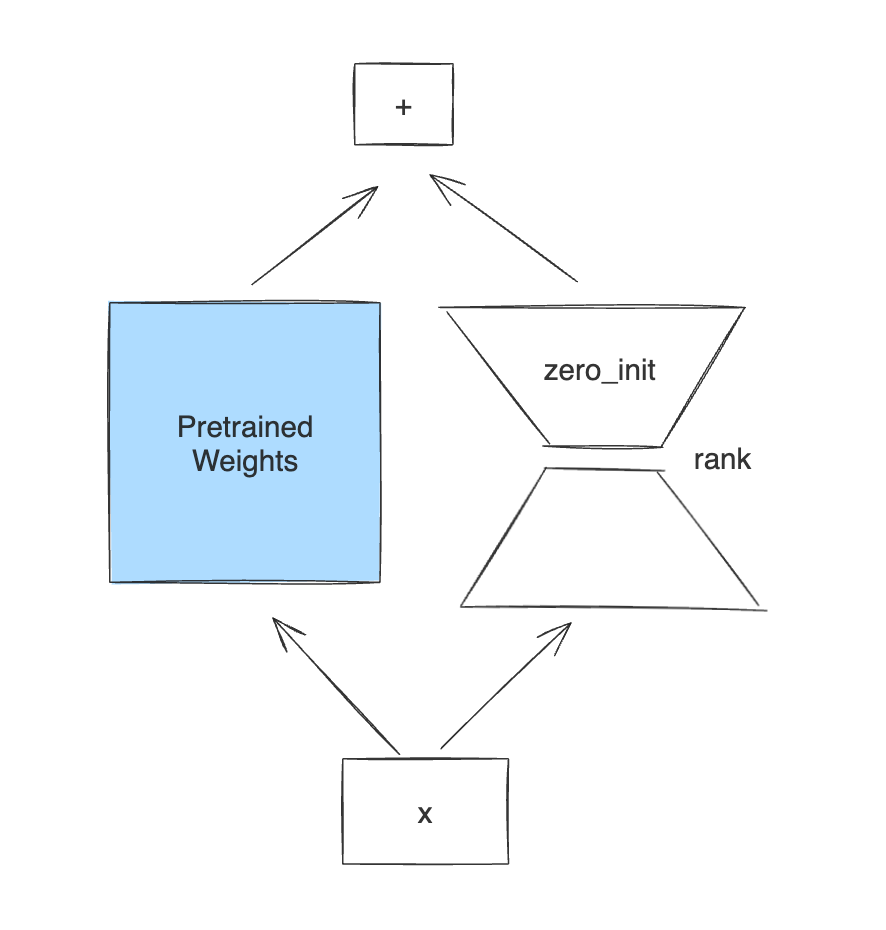


In [23]:
class Lora(fl.Chain):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        rank: int = 16,
    ) -> None:
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.scale: float = 1.0

        super().__init__(
            fl.Linear(in_features=in_features, out_features=rank, bias=False),
            fl.Linear(in_features=rank, out_features=out_features),
        )

        nn.init.normal_(tensor=self.Linear_1.weight, std=1 / self.rank)
        nn.init.zeros_(tensor=self.Linear_2.weight)


lora = Lora(128, 128)
x = torch.randn(1, 1, 128)
print(lora(x).shape)
lora

torch.Size([1, 1, 128])


(CHAIN) Lora(in_features=128, out_features=128)
    ├── Linear(in_features=128, out_features=16) #1
    └── Linear(in_features=16, out_features=128) #2

Now we want to be able to insert this into any `Linear` layer of the Model. To do that, we can use the `Adapter` class.

In [24]:
from refiners.fluxion.adapters import Adapter


class LoraAdapter(fl.Sum, Adapter[fl.Linear]):
    def __init__(
        self,
        target: fl.Linear,
        rank: int = 16,
    ) -> None:
        self.in_features = target.in_features
        self.out_features = target.out_features
        self.rank = rank
        # the setup_adapter method is used to remove boilerplate code
        with self.setup_adapter(target):
            super().__init__(
                target,
                Lora(
                    in_features=target.in_features,
                    out_features=target.out_features,
                    rank=rank,
                ),
            )


attention = Attention()
linear = attention.ensure_find(fl.Linear)
adapter = LoraAdapter(linear)
print(
    f"""
Adapter:
{repr(adapter)}

Note that the original attention is not modified:
{repr(attention)}  
"""
)


Adapter:
(SUM) LoraAdapter()
    ├── Linear(in_features=128, out_features=128)
    └── (CHAIN) Lora(in_features=128, out_features=128)
        ├── Linear(in_features=128, out_features=16) #1
        └── Linear(in_features=16, out_features=128) #2

Note that the original attention is not modified:
(RES) Attention()
    ├── (PAR)
    │   └── Linear(in_features=128, out_features=128) (x3)
    ├── ScaledDotProductAttention(num_heads=8)
    └── Linear(in_features=128, out_features=128)  



Let's now `inject` the `Adapter` into the `FeedForward` layer of the `TransformerLayer`. One subtlety is that the `Linear` layer is considered a `WeightedModule` and as such can belong to multiple `Chain` at the same time. So we need to specify which `Chain` we want to inject the `Adapter` into.

In [25]:
adapter.inject(parent=attention.Parallel)
print(repr(attention))

# we can also `eject` the adapter to get back to normal
adapter.eject()
print(repr(attention))

(RES) Attention()
    ├── (PAR)
    │   ├── (SUM) LoraAdapter()
    │   │   ├── Linear(in_features=128, out_features=128)
    │   │   └── (CHAIN) Lora(in_features=128, out_features=128)
    │   │       ├── Linear(in_features=128, out_features=16) #1
    │   │       └── Linear(in_features=16, out_features=128) #2
    │   └── Linear(in_features=128, out_features=128) (x2)
    ├── ScaledDotProductAttention(num_heads=8)
    └── Linear(in_features=128, out_features=128)
(RES) Attention()
    ├── (PAR)
    │   └── Linear(in_features=128, out_features=128) (x3)
    ├── ScaledDotProductAttention(num_heads=8)
    └── Linear(in_features=128, out_features=128)


Finally let's write a top-level adapter that will inject the `Adapter` into all the `Linear` layers of the `ViT`.

In [26]:
from typing import Self


class ViTLoraAdapter(fl.Chain, Adapter[ViT]):
    def __init__(
        self,
        target: ViT,
        rank: int = 16,
    ) -> None:
        self.rank = rank
        with self.setup_adapter(target):
            super().__init__(target)

        # Let's wrap all the Linear layers in the ViT model into LoraAdapters
        self.sub_adapters: list[tuple[LoraAdapter, fl.Chain]] = []
        for linear, parent in self.target.walk(fl.Linear):
            self.sub_adapters.append((LoraAdapter(target=linear, rank=rank), parent))

    def inject(self, parent: fl.Chain | None = None) -> Self:
        for adapter, adapter_parent in self.sub_adapters:
            adapter.inject(adapter_parent)
        return super().inject(parent)

    def eject(self) -> None:
        for adapter, _ in self.sub_adapters:
            adapter.eject()
        super().eject()


vit = ViT()
x = torch.randn(1, 3, 224, 224)
points = torch.randn(5, 2)
vit.set_context("vit", {"points_tensor": points})
adapter = ViTLoraAdapter(vit)
adapter.inject()  # since `ViT` has no parent, no need to pass it to `inject`
print(repr(vit))
print(vit(x).shape)

# we can also `eject` the adapter to get back to normal
adapter.eject()
print(repr(vit))

(CHAIN) ViT()
    ├── (PASS) PointEncoder()
    │   ├── UseContext(context=vit, key=points_tensor)
    │   ├── (SUM) LoraAdapter() #1
    │   │   ├── Linear(in_features=2, out_features=128)
    │   │   └── (CHAIN) Lora(in_features=2, out_features=128)
    │   │       ├── Linear(in_features=2, out_features=16) #1
    │   │       └── Linear(in_features=16, out_features=128) #2
    │   ├── SiLU() #1
    │   ├── (SUM) LoraAdapter() #2
    │   │   ├── Linear(in_features=128, out_features=128)
    │   │   └── (CHAIN) Lora(in_features=128, out_features=128)
    │   │       ├── Linear(in_features=128, out_features=16) #1
    │   │       └── Linear(in_features=16, out_features=128) #2
    │   ├── SiLU() #2
    │   ├── (SUM) LoraAdapter() #3
    │   │   ├── Linear(in_features=128, out_features=128)
    │   │   └── (CHAIN) Lora(in_features=128, out_features=128)
    │   │       ├── Linear(in_features=128, out_features=16) #1
    │   │       └── Linear(in_features=16, out_features=128) #2
    │   